In [1]:
import os
import numpy as np
import rasterio
import eoreader
from eoreader.reader import Reader
from eoreader.bands import NIR
from rasterio.plot import show, adjust_band
from matplotlib import pyplot as plt

In [2]:
# Base folder
prod_folder = os.path.join("/home", "data", "DS3", "CI", "eoreader", "optical")

# Landsat-9 OLI-TIRS collection 2 (archived in a tar file)
l9_path = os.path.join(prod_folder, "LC09_L1TP_200030_20220201_20220201_02_T1.tar")

# Pléiades, as a folder (extracted data)
pld_path = os.path.join(prod_folder, "IMG_PHR1A_PMS_001")

# Sentinel-2 L2A (archived in a zip file)
s2_path = os.path.join(prod_folder, "S2A_MSIL1C_20200824T110631_N0209_R137_T30TTK_20200824T150432.SAFE.zip")

# Group all these paths
paths = [l9_path, pld_path, s2_path]

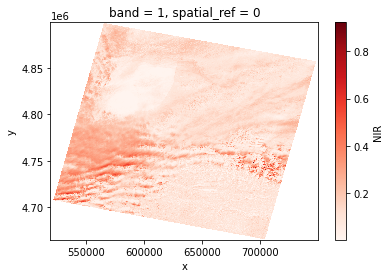

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


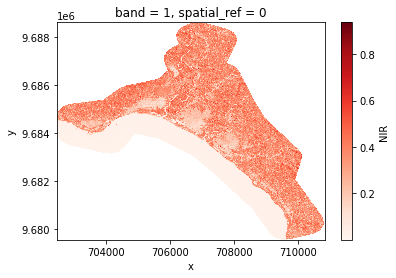

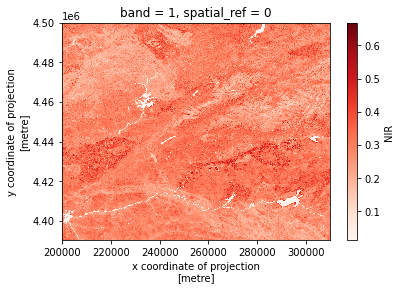

In [3]:
%matplotlib inline
reader = Reader()
for path in paths:
    # Open the product
    prod = reader.open(path)
    
    # Load NIR
    nir = prod.load(NIR)[NIR]
    
    # Plot
    nir[:, ::5, ::5].plot(cmap="Reds")
    plt.show()

In [4]:
l9_nir_path = rf"tar://{l9_path}!LC09_L1TP_200030_20220201_20220201_02_T1_B5.TIF"

with rasterio.open(l9_nir_path) as l9_nir_ds:
    l9_nir = l9_nir_ds.read()
    l9_tr = l9_nir_ds.transform

In [5]:
# First convert the band to float (as we want reflectance values and why not nans in place of nodata)
l9_nir = l9_nir.astype(np.float32)

# Set nodata, for landsat it is where the band is null (before converting to reflectance!)
l9_nir = np.where(l9_nir==0, np.nan, l9_nir)

# Convert to reflectance
# We can look in the metadata file (LC09_L1TP_200030_20220201_20220201_02_T1_MTL.xml) inside the zip to go faster for this specific band.
# However, you will need to repeat this operation for any other band or product
# Or set it in stone, but be careful as the specification may change...
l9_nir_c_add = -0.100000
l9_nir_c_mul = 2.0000E-05
l9_nir_refl = l9_nir * l9_nir_c_mul + l9_nir_c_add

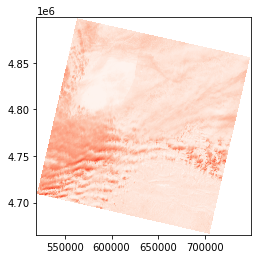

<AxesSubplot:>

In [6]:
show(adjust_band(l9_nir_refl), transform=l9_tr, cmap='Reds')

In [7]:
pld_nir_path = os.path.join(pld_path, "DIM_PHR1A_PMS_202005110231585_ORT_5547047101.XML")

with rasterio.open(pld_nir_path) as pld_nir_ds:
    pld_nir = pld_nir_ds.read()
    pld_tr = pld_nir_ds.transform

In [8]:
# Convert the band to float for consistency
pld_nir = pld_nir.astype(np.float32)

# Set nodata, for landsat it is where the band is null
pld_nir = np.where(pld_nir==0, np.nan, pld_nir)

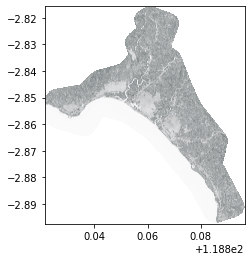

<AxesSubplot:>

In [9]:
show(adjust_band(pld_nir), transform=pld_tr, cmap='Reds')

In [10]:
s2_nir_path = os.path.join(
    f"zip://{s2_path}",
    "S2A_MSIL1C_20200824T110631_N0209_R137_T30TTK_20200824T150432.SAFE!",
    "GRANULE",
    "L1C_T30TTK_A027018_20200824T111345",
    "IMG_DATA",
    "T30TTK_20200824T110631_B08.jp2"
)

with rasterio.open(s2_nir_path) as s2_nir_ds:
    s2_nir = s2_nir_ds.read()
    s2_tr = s2_nir_ds.transform

In [11]:
# First convert the band to float (as we want reflectance values and why not nans in place of nodata)
s2_nir = s2_nir.astype(np.float32)

# Set nodata, for Sentinel-2 it is where the band is null
s2_nir = np.where(s2_nir==0, np.nan, s2_nir)

# Convert to reflectance
s2_nir_c_add = 0  # This changes with baseline 04.00!
s2_nir_c_mul = 1/10000
s2_nir_refl = s2_nir * s2_nir_c_mul + s2_nir_c_add

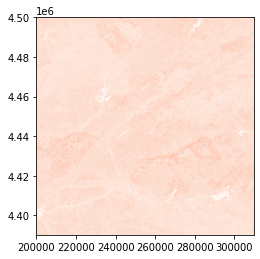

<AxesSubplot:>

In [12]:
show(adjust_band(s2_nir_refl), transform=s2_tr, cmap='Reds')